In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
token="Us3wFmXGgAj_1cUtHAAR"

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:44: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('./Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:46: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('./volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:48: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:48: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:51: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future ve

# Presentation to be like "Time Varying Liquidity and Momentum Profits (2015) paper

Rank by deciles, HML (8,9,10) - (1,2,3).  Save monthly returns (equal (risk?) weighted) and if you want to annualized then resample.


Then correlation matrix 
* Overall market vol?
* Market illiquidity (median Amihud through time series)


# Amihud (2002) Annual portfolio sorts

In [5]:
data=calc_zscore_expanding_window(amihud.dropna(how='all'),12).dropna(how='all')
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:275: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=12,window=100000000,center=False).mean()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)
tsmom_model.py:275: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=12,window=100000000,center=False).std()
  return (df-pd.rolling_mean(df,100000000,min_periods=min_per))/pd.rolling_std(df,100000000,min_periods=min_per)


In [6]:
sector_rtns={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_rtns[sect]=np.log(cleansed[d_map[sect]].resample(rule='m',how='last')).diff().dropna(how='all')
sector_rtns['All']=np.log(cleansed.resample(rule='m',how='last')).diff().dropna(how='all')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """


In [7]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,2)

tsmom_model.py:240: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()
  mkts=quantile_columns(rank_data.resample(rule='a',how='median'),year,number_of_buckets,i)
tsmom_model.py:241: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  rtns = price_data.resample(rule='m',how='last')[mkts].pct_change()[str(y+1)].mean(axis=1)


In [8]:
factors=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']

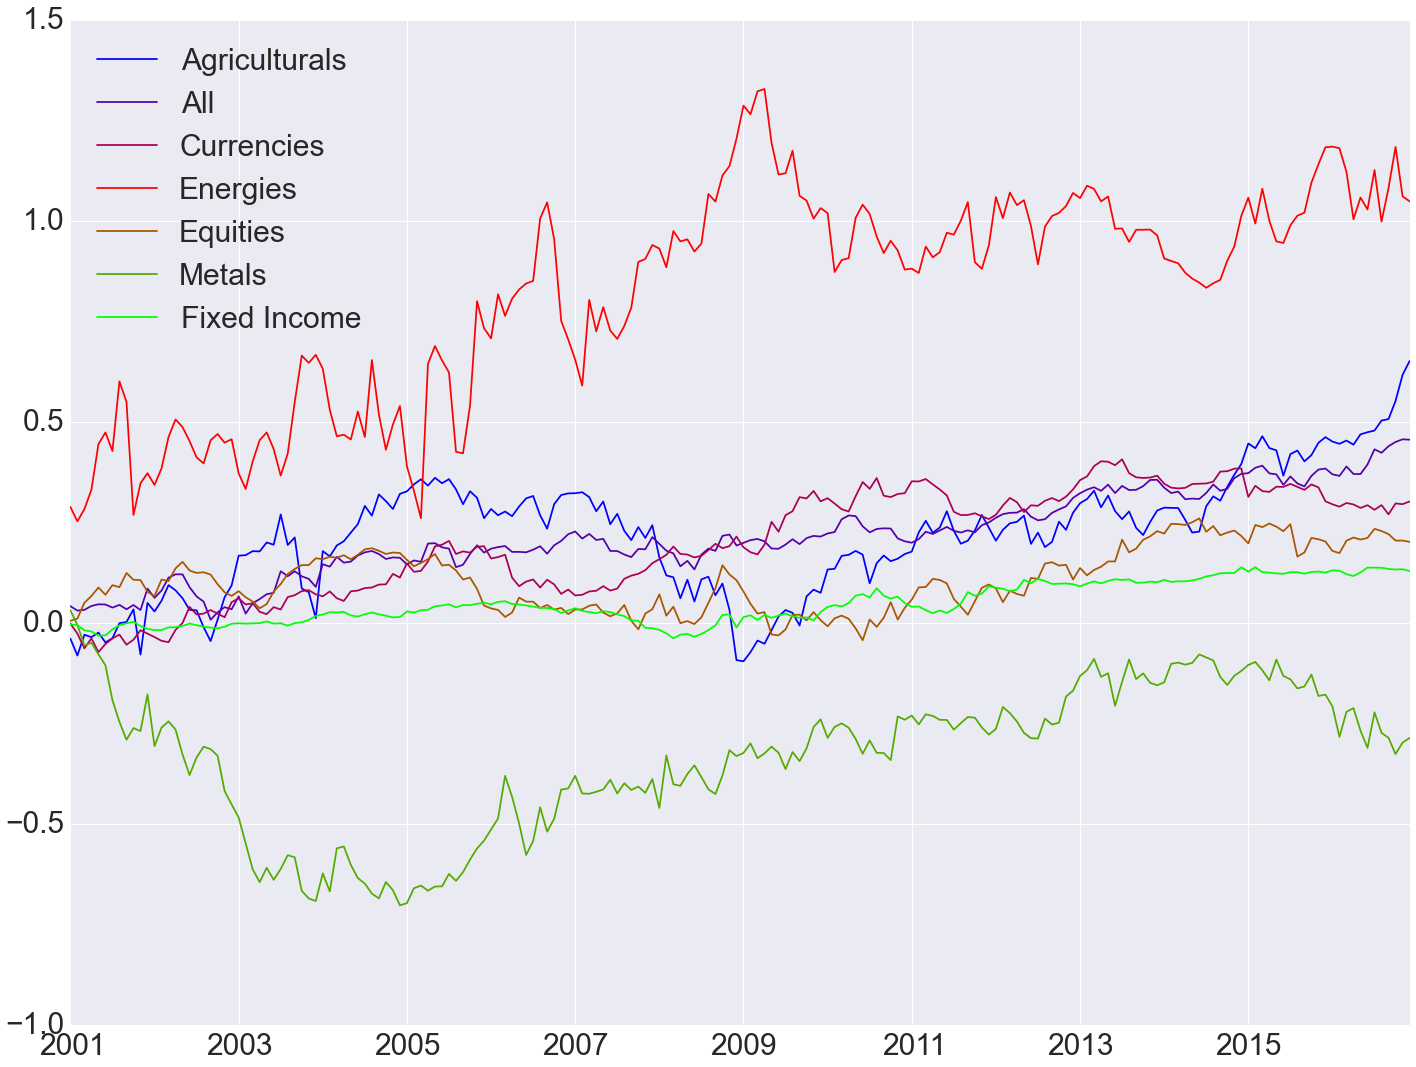

In [9]:
factors.cumsum().plot(colormap='brg')

In [10]:
final_res=pd.DataFrame()
betas_res=pd.DataFrame()
alpha={}
tstat={}
for sec in ['All']:
    ind=factors.index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors[sec],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AA']=res.params *100
        betas_res['AA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['Amihud Annual']=res.params
final_res['Amihud Annual T']=res.tvalues

# FHT Annual portfolio sorts

In [11]:
FHT=calculate_FHT(cleansed)
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')
sector_zscores={}
d_map=sector_map(FHT)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

tsmom_model.py:288: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:289: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:290: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:290: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:275: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=3,window=10000

In [12]:
sector_portfolio_sorts={}
for s in sector_zscores.keys():
    sector_portfolio_sorts[s]=quantile_portfolios_annual(sector_zscores[s],cleansed,2)
sector_portfolio_sorts['All']=quantile_portfolios_annual(data,cleansed,2)

In [13]:
factors_FHT=pd.DataFrame()
for s in sector_portfolio_sorts.keys():
    factors_FHT[s]=sector_portfolio_sorts[s]['1']-sector_portfolio_sorts[s]['0']


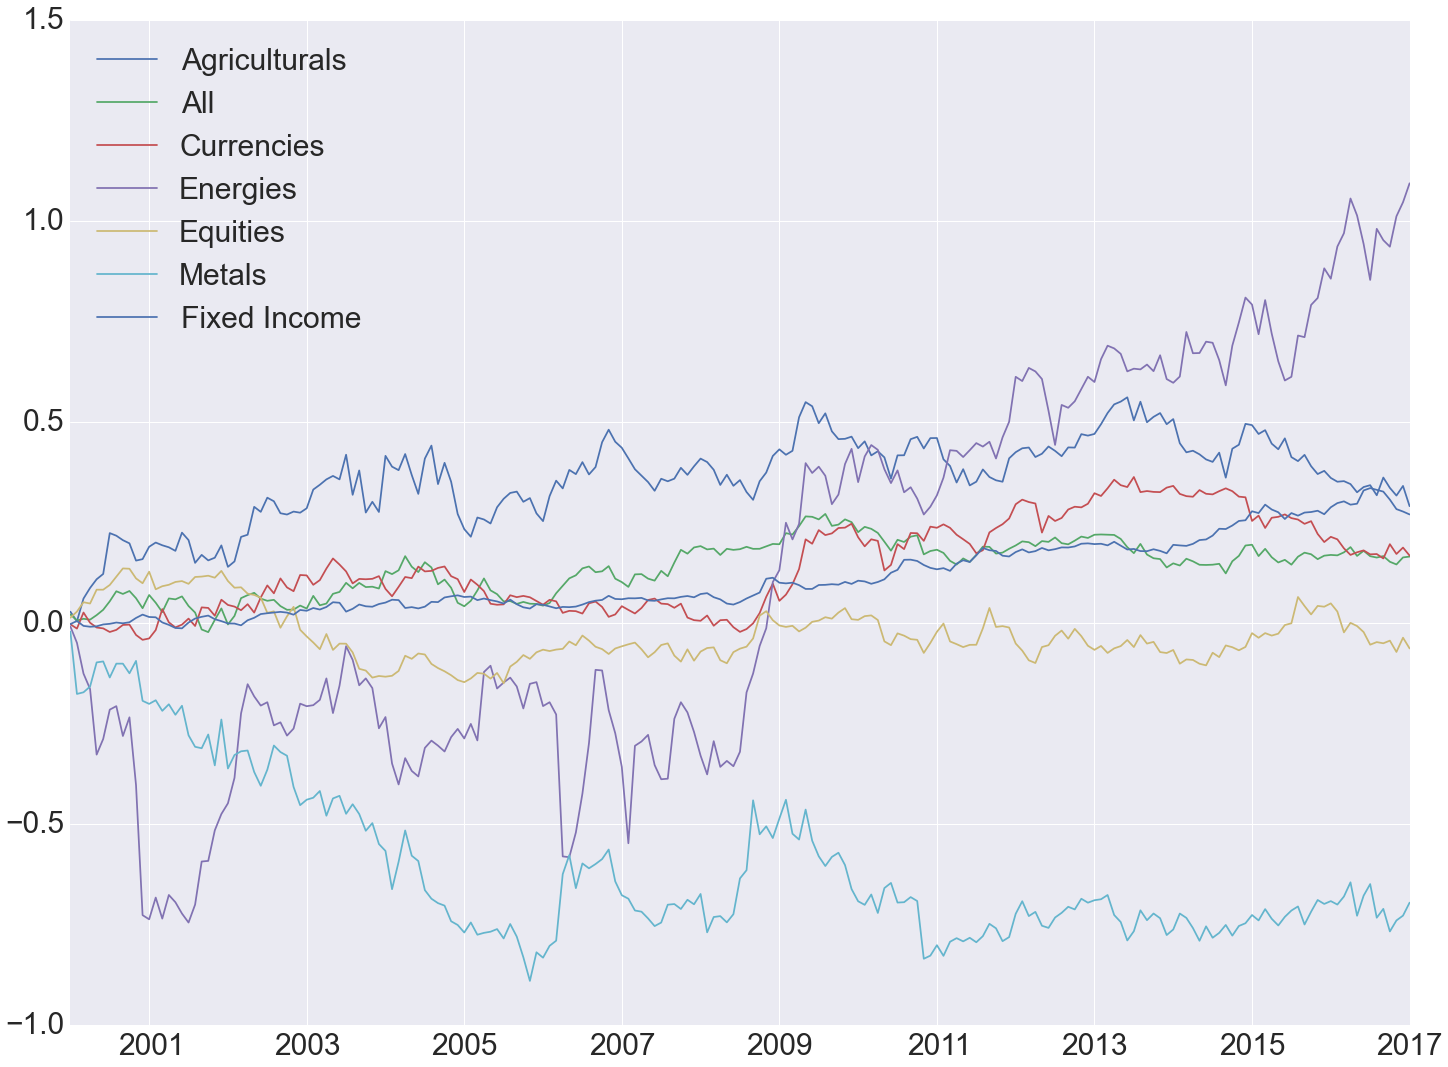

In [14]:
factors_FHT['2000':].cumsum().plot()

In [15]:

sec='All'
ind=factors_FHT['2000':'2016'].index
reges=get_aqr_factors(sec).loc[ind]
reges['Market Return']=sector_rtns[sec].mean(axis=1)
reges['const']=1
res=sm.OLS(factors_FHT[sec]['2000':'2016'],reges[['Market Return','const']]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
res=sm.OLS(factors_FHT[sec]['2000':'2016'],reges[['Market Return','const']]).fit(cov_type='HAC',cov_kwds={'maxlags':1})


In [16]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                    All   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.841
Date:                Thu, 23 Aug 2018   Prob (F-statistic):             0.0289
Time:                        22:58:12   Log-Likelihood:                 543.21
No. Observations:                 204   AIC:                            -1082.
Df Residuals:                     202   BIC:                            -1076.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Market Return     0.1148      0.052      2.200

In [17]:
alpha={}
tstat={}
for sec in ['All']:
    ind=factors_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_FHT[sec]['2000':'2016'],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FA']=res.params  *100
        betas_res['FA_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['FHT Annual']=res.params
final_res['FHT Annual T']=res.tvalues

In [18]:
res.params

VAL             -0.209712
MOM             -0.215796
Market Return    0.085551
const            0.001679
dtype: float64

# Monthly portoflio sorts

In [19]:
amihud_monthly = read_monthly(amihud=True)

In [ ]:
factors_monthly=pd.DataFrame()
for s in amihud_monthly.keys():
    factors_monthly[s]=amihud_monthly[s]['1']-amihud_monthly[s]['0']


In [ ]:
factors_monthly.cumsum().plot(colormap='jet')

In [ ]:
alpha={}
tstat={}
for sec in ['All']:
    ind=factors_monthly['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly[sec].loc[ind],reges.loc[ind]).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['AM']=res.params  *100
        betas_res['AM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['Amihud Monthly']=res.params
final_res['Amihud Monthly T']=res.tvalues

In [ ]:
final_res.round(2).T

# Monthly FHT

In [ ]:
FHT_monthly = read_monthly(amihud=False)

In [ ]:
factors_monthly_FHT=pd.DataFrame()
for s in FHT_monthly.keys():
    factors_monthly_FHT[s]=FHT_monthly[s]['1']-FHT_monthly[s]['0']


In [ ]:
alpha={}
tstat={}
for sec in ['All']:
    ind=factors_monthly_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly_FHT[sec].loc[ind],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FM']=res.params  *100
        betas_res['FM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['FHT Monthly']=res.params
final_res['FHT Monthly T']=res.tvalues

In [ ]:
final_res

In [ ]:
betas_res

In [ ]:
all_market = pd.DataFrame()
all_market['Amihud Annual']=factors.All
all_market['FHT Annual']=factors_FHT.All
all_market['Amihud Monthly']=factors_monthly.All
all_market['FHT Monthly']=factors_monthly_FHT.All

In [ ]:
all_market.cumsum().plot()

In [ ]:
alpha={}
tstat={}
for sec in ['All']:
    ind=factors_monthly_FHT['2000':'2016'].index
    reges=get_aqr_factors(sec).loc[ind]
    reges['Market Return']=sector_rtns[sec].mean(axis=1)
    reges['const']=1
    res=sm.OLS(factors_monthly_FHT[sec].loc[ind],reges).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    if sec=='All':
        betas_res['FM']=res.params  *100
        betas_res['FM_T']=res.tvalues
    alpha[sec]=res.params.const
    tstat[sec]=res.tvalues.const
final_res['FHT Monthly']=res.params
final_res['FHT Monthly T']=res.tvalues

In [ ]:
final_res.T.columns

# Alpha values 

$$r_{liquidity,t} = \alpha + \beta_1 r_{AssetClass,t} + \beta_2 MOM_{AssetClass,t} +
\beta_3 VAL_{AssetClass,t} + \varepsilon_t $$

In [ ]:
print(final_res.T[[ u'const', u'Market Return',u'VAL', u'MOM']].round(2).to_latex())

# These results are so bad from the beta's to the factors point of view from all markets.  It's just way to high for FHT

I am not going to present them in the results.

In [39]:
print(betas_res.T.round(2)[['const','Market Return','VAL','MOM']].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  const &  Market Return &    VAL &    MOM \\
\midrule
AA   &   0.16 &           2.24 &   4.59 &  -2.89 \\
AA\_T &   1.43 &           0.42 &   0.63 &  -0.38 \\
FA   &   0.17 &           8.56 & -20.97 & -21.58 \\
FA\_T &   1.40 &           1.70 &  -2.33 &  -3.32 \\
AM   &   0.15 &           1.21 &   2.55 &  -4.96 \\
AM\_T &   1.27 &           0.23 &   0.35 &  -0.63 \\
FM   &   0.01 &          13.26 & -14.12 & -13.37 \\
FM\_T &   0.08 &           2.63 &  -1.42 &  -1.89 \\
\bottomrule
\end{tabular}

